# The Problem of Cyber Bullying
> With the rise of social media and degraded morality, cyber bullying has become a terrible menace of modern times. Social Media grants us anonymity, 
which leads some distorted minds to think they can get away with anything. So they pick out on people, befriend them and then shower them with hate.
    
> The problem may seem to some to be another sort of high school bully. But cyber bullying is done on social media where information is permanant. 
So this becomes a lifelong trauma for victims. Depression and Suicide are common after effects of this nemesis, but not much has been done to curb this menace.

# Importing the Data

In [44]:
# Imports for common tasks, models imported later
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import gensim
from sklearn.metrics import fbeta_score
import missingno as msn
from IPython.display import Image
from transformers import BertTokenizer, BertModel
import lightgbm as lgb
%matplotlib inline

In [45]:
#df = pd.read_csv("/kaggle/input/formspring-csv/formspring.csv", nrows=1000)
df = pd.read_csv("/kaggle/input/formspring-csv/formspring.csv")
# See first few rows
df.head()

,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
0,aguitarplayer94,Q: what&#039;s your favorite song? :D<br>A: I ...,what&#039;s your favorite song? :D<br>,I like too many songs to have a favorite,None,No,0,NaN,No,0,NaN,No,0,NaN
1,aprilpooh15,Q: <3<br>A: </3 ? haha jk! <33,<3,</3 ? haha jk! <33,None,No,0,NaN,No,0,NaN,No,0,NaN
2,aprilpooh15,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,None,No,0,NaN,No,0,NaN,No,0,NaN
3,aprilpooh15,Q: (:<br>A: ;(,(:,;(,None,No,0,NaN,No,0,NaN,No,0,NaN
4,aprilpooh15,Q: ******************MEOWWW*******************...,******************MEOWWW*************************,*RAWR*?,None,No,0,NaN,No,0,NaN,No,0,NaN


# Exploration of the dataset

## 1. BarPlot of missing values

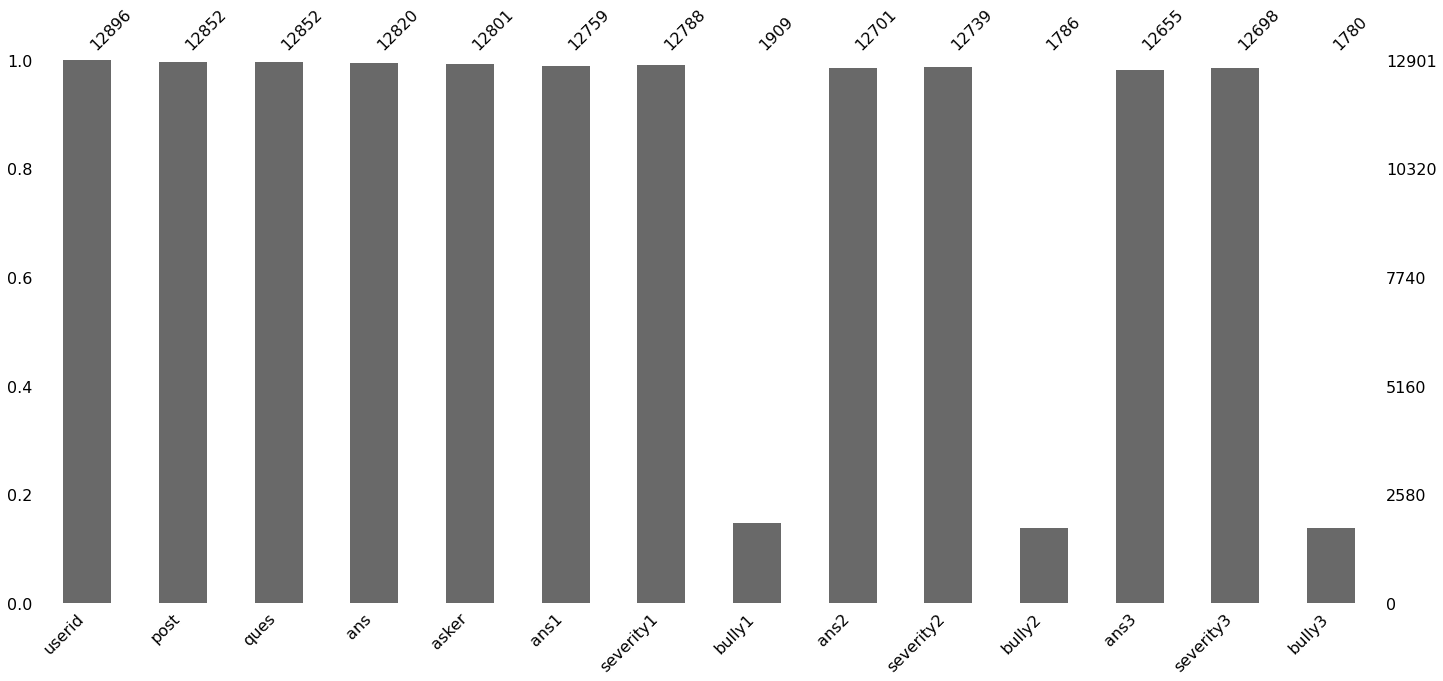

In [46]:
# missing values visualisation
msn.bar(df);

# Insights about the data set
* userid - userid of a person giving the answer to a post
* post - The post and it's reply. Separated by Q: and A.
* ques and ans - The question and answer. The same information is available in post, so we drop post
* asker - id of the person asking the question.
* ans #, severity #, bully # - answer by mechanical turk, severity score assigned, bully word/phrase

In [47]:
df.drop(['post', 'asker', 'bully1', 'bully2', 'bully3'], axis = 1, inplace = True)

In [48]:
df.head()

,userid,ques,ans,ans1,severity1,ans2,severity2,ans3,severity3
0,aguitarplayer94,what&#039;s your favorite song? :D<br>,I like too many songs to have a favorite,No,0,No,0,No,0
1,aprilpooh15,<3,</3 ? haha jk! <33,No,0,No,0,No,0
2,aprilpooh15,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,No,0,No,0,No,0
3,aprilpooh15,(:,;(,No,0,No,0,No,0
4,aprilpooh15,******************MEOWWW*************************,*RAWR*?,No,0,No,0,No,0


In [49]:
#unique_values = df['severity1'].unique()

#print(unique_values) 

# Imputing Missing Values and Replacing values

## 1. ans columns
NaN for ans columns indicates No Bully found. We will map every Yes to 1 and every No or NaN to 0

In [50]:
def impute_ans_columns(value):
    v = ['No','nan']
    if value in v:
        return 0
    return 1

In [51]:
for col in ['ans1', 'ans2', 'ans3']:
    df[col] = df[col].apply(impute_ans_columns)
df.sample(10)

,userid,ques,ans,ans1,severity1,ans2,severity2,ans3,severity3
7341,zooshay,Yep do you like it or is that also to hardcor...,no i just downloaded it its cool deep though ...,0,0,0,0,0,0
12842,outlaw9000,Would you want to know when you die or be lik...,unexpectedly,0,0,0,0,0,0
8678,kellyblake1,AWWW KELLY :&#039;( YOU&#039;RE GONG TO MAKE M...,Love you toooooo! The love is back!!!! <33333...,0,0,0,0,0,0
4428,freshswagg21,Softy ass LMAOO,huh naw but im not a mean as guy lol?,1,3,0,0,1,1
7230,zooshay,who would win? you or gmac on sydney city roads?,LMFAO!! me by far,0,0,0,0,0,1
12104,outlaw9000,money or love?,Money Pink has a GREAT line >> keep your drin...,0,0,0,0,0,0
1510,teaachgee,How many times have you had the hippups today? :D,none.,0,0,0,0,0,0
2457,teaachgee,Would a fly without wings be called a walk?,hahahah idk.,0,0,0,0,0,0
817,teaachgee,Can we be in two places at once?,Yes. Standing over the border line. Ive been ...,0,0,0,0,0,0
9739,kellyblake1,What does it mean to you to allow another pers...,It means I let them in? I embrace their feeli...,0,0,0,0,0,0


## 2. severity columns
* NaN/None was associated with a No(0) that is 0 severity mostly.

So we will replace all NaN/None with 0.

In [52]:
def impute_severity_columns(value):
    '''Value will be a string. We need to convert it to int'''
    v = ['nan', 'None', '0']
    if value in v:
        return 0
    try:
        return int(value)
    except ValueError as e:
        #print(value)
        return 5

In [53]:
for col in ['severity1', 'severity2', 'severity3']:
    df[col] = df[col].apply(impute_severity_columns)

In [54]:
df.sample(10)

,userid,ques,ans,ans1,severity1,ans2,severity2,ans3,severity3
2524,teaachgee,Wouldn&#039;t alot of people out of jobs if we...,Scientists. Doctors. Engineers. r Because we ...,0,0,0,0,0,0
5081,lauraaatxd,YOU AND TONY ARE SOOOOOO CUTE TOGETHER:3,aw thanksss<3,0,0,0,0,0,0
239,joielovesu,i lovee joiee<3,ii lovee yuuu moree:P,0,0,0,0,0,0
1925,teaachgee,What age would you liek to get married?,now or in a year or so,0,0,0,0,0,0
5236,zooshay,beach or the mountains?,beach,0,0,0,0,0,0
337,moonbeemashlee,favorite color?,purple : ),0,0,0,0,0,0
1447,teaachgee,how are you such a hottie?,Idk. what makes me a hottie? haha,0,0,0,0,0,0
4930,lauraaatxd,only half amazing as you.,Lol that's very sweet<3 who are you?,0,0,0,0,0,0
11802,outlaw9000,I love your bio thats like my life story.,nice,0,0,0,0,0,0
2195,teaachgee,What would be worse; Finding out there is life...,worse? that there isn't.,0,0,0,0,0,0


# Creating the target feature
Since in this dataset, we have not been given any target feature, we will create our own target feature.

```python
isBully = ((ans1 * severity1) + (ans2 * severity2) + (ans3 * severity3)) / 30 >= 0.20
```

We are taking 0.2 as our threshold

In [55]:
df['IsBully'] = (
    (df.ans1 * df.severity1 + df.ans2 * df.severity2 + df.ans3 * df.severity3) / 30) >= 0.0333

# Remove uneccessary columns
df_2 = df.drop(['userid','ans1', 'severity1','ans2','severity2','ans3','severity3'], axis = 1)

In [56]:
df_2.sample(10)

,ques,ans,IsBully
483,YOU SHOULD DIE,kay,True
8586,Would you rather be a famous musician or a fam...,famous actor! i can't play or sing for my life!,False
9874,Whatu2019s the funniest movie youu2019ve ever ...,Hmmmm I remember watching something and it w...,False
5522,DU U eVA hAd eRotic thoughTs abouT me? DEScIBE...,yes i have and seen as this is a g rated site...,True
1990,What do you need to change about yourself?,My anger. I get frustrated to easily. It suck...,False
6986,What it do what it do what it do Girly! XD ....,:( didnt have to rip them :( could ov just as...,False
7145,When u getting your next car?,aww i want one now =( but im not allowd to ri...,False
3188,because you like him,hahahahahaahahahahahahhhahaha r why does ever...,False
8795,Do you believe in Karma and Destiny?,I would like to believe in those things it i...,False
1588,I want my mom to _________.,come over and cook me dinner. Shes an amazing...,False


In [57]:
false_count = (df_2['IsBully'] == False).sum()
print(f"Number of rows where isBully is False: {false_count}")

Number of rows where isBully is False: 10925


In [58]:
true_count = (df_2['IsBully'] == True).sum()
print(f"Number of rows where isBully is True: {true_count}")

Number of rows where isBully is True: 1976


# Text Cleaning

In [59]:
for col in ['ques', 'ans']:
    df_2[col] = df_2[col].str.replace("&#039;", "'") # Put back the apostrophe

    df_2[col] = df_2[col].str.replace("<br>", "") 
    df_2[col] = df_2[col].str.replace("&quot;", "") 
    #df_2[col] = df_2[col].str.replace("<3", "love")
    
df_2.head()

,ques,ans,IsBully
0,what's your favorite song? :D,I like too many songs to have a favorite,False
1,<3,</3 ? haha jk! <33,False
2,hey angel you duh sexy,Really?!?! Thanks?! haha,False
3,(:,;(,False
4,******************MEOWWW*************************,*RAWR*?,False


In [60]:
df_2.shape

(12901, 3)

In [61]:
df_2 = df_2.dropna()

In [62]:
df_2.shape

(12818, 3)

# Train Test Split

In [63]:
from sklearn.model_selection import train_test_split
X, y = df_2.iloc[:, :-1], df_2.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=42, shuffle=True)


# reset indices as indices hold no value for us
X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

# Tokenizing and Feature Engineering

In [64]:
def tokenize(text):
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", str(text).lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word).lower().strip() for word in tokens if word not in stop_words]

    return tokens

In [65]:
is_bert_mini=False
is_bert_base=False
is_bert_large=True
is_glove=False
is_openai=False
isBert = is_bert_mini or is_bert_base or is_bert_large 

In [66]:
## getting GloVe word2vectors
if is_glove:
    from gensim.scripts.glove2word2vec import glove2word2vec
    # convert txt to word2vec format for easy access
    glove_input_file = '../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt'
    word2vec_output_file = 'glove.6B.50d.txt.word2vec'
    glove2word2vec(glove_input_file, word2vec_output_file)

    from gensim.models import KeyedVectors
    # load the Stanford GloVe model
    filename = './glove.6B.50d.txt.word2vec'
    model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [67]:
# Load tokenizer and model
if is_bert_mini:
    checkpoint = "prajjwal1/bert-small"
    bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)

    bert_model = BertModel.from_pretrained(checkpoint)

In [68]:
# Load tokenizer and model
if is_bert_base:
    # Load pre-trained BERT tokenizer and model
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')

In [69]:
# Load tokenizer and model
if is_bert_large:
    # Load pre-trained BERT tokenizer and model
    bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
    bert_model = BertModel.from_pretrained('bert-large-uncased')

In [70]:
if is_glove:
    embedding_vector_length = 50
else:
    embedding_vector_length = bert_model.config.hidden_size

In [71]:
def putWordVector(text):
    '''Returns Word Vectors for passed unclean string'''
    clean_text = tokenize(text) # list of words
    wordvecFinal = np.zeros((embedding_vector_length,), dtype=np.float32)
    
    for word in clean_text:
        try:
            word_vec = model[word]
            wordvecFinal = np.add(word_vec, wordvecFinal)
        except KeyError as e:
            continue
    return wordvecFinal

In [72]:
def get_bert_embeddings(text):
    text = tokenize(text)
    
    # Ensure the text is either a string or a list of strings
    if text is None or text == "":
        return np.zeros(embedding_vector_length)  # Return zeros for missing or empty texts

    # Ensure text is a string or a list of strings
    if isinstance(text, str):
        text = " ".join(text)  # Wrap the string in a list to make it compatible with the tokenizer
    if len(text) == 0:
        return np.zeros(embedding_vector_length)  # Return zeros for missing or empty texts
    # Tokenize input text
    inputs = bert_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=embedding_vector_length)

    # Get BERT embeddings
    with torch.no_grad():
        outputs = bert_model(**inputs)
    
    # Extract the last hidden state (token embeddings)
    embeddings = outputs[0]
    
    #   
    cls_embedding = embeddings[0, 0, :].squeeze().numpy()  # [CLS] token is the first token
    
    return cls_embedding

In [73]:
if is_openai:
    !pip install openai
    import tiktoken
    from utils.embeddings_utils import get_embedding
    embedding_model = "text-embedding-3-small"
    embedding_encoding = "cl100k_base"
    max_tokens = 1000  # the maximum for text-embedding-3-small is 8191
    encoding = tiktoken.get_encoding(embedding_encoding)
    client = OpenAI()
# This may take a few minutes
    df["embedding"] = df.combined.apply(lambda x: get_embedding(x, model=embedding_model))

In [74]:
def addWordVectors(df, colName):
    ''' Adds word vectors to the dataframe, returns the updated dataframe.
    df: pandas DataFrame
    colName: Name of the column which contains strings
    isBert: If True, use BERT embeddings, else use putWordVector function '''

    # Apply the correct embedding function
    if isBert:
        df['embeddings'] = df[colName].apply(get_bert_embeddings)
        # Convert the embeddings column (list of numpy arrays) into a DataFrame with 512 columns
        print(df['embeddings'].apply(lambda x: len(x)).head())

        columnNames = [colName + str(i) for i in range(embedding_vector_length)]
        df_vectors = pd.DataFrame(df['embeddings'].to_list(), columns=columnNames)
        # Optionally drop the original text column
        df = df.drop(columns=['embeddings']).join(df_vectors)
        return df
    else:
        df_new = df[colName].apply(putWordVector)
    columnNames = [colName + str(i) for i in range(embedding_vector_length)]
   
    # Convert the list of embeddings to a DataFrame
    df_vectors = pd.DataFrame(df_new.tolist(), columns=columnNames)

    # Concatenate the original DataFrame with the new word vectors DataFrame
    df_new = pd.concat([df, df_vectors], axis=1)

    # Optionally drop the original text column
    df_new = df_new.drop([colName], axis=1)
    
    return df_new 

In [75]:
X_train, X_val = addWordVectors(addWordVectors(X_train, 'ques'), 'ans'), addWordVectors(addWordVectors(X_val, 'ques'), 'ans')
X_train.head()

0    1024
1    1024
2    1024
3    1024
4    1024
Name: embeddings, dtype: int64
0    1024
1    1024
2    1024
3    1024
4    1024
Name: embeddings, dtype: int64
0    1024
1    1024
2    1024
3    1024
4    1024
Name: embeddings, dtype: int64
0    1024
1    1024
2    1024
3    1024
4    1024
Name: embeddings, dtype: int64


,ques,ans,ques0,ques1,ques2,ques3,ques4,ques5,ques6,ques7,...,ans1014,ans1015,ans1016,ans1017,ans1018,ans1019,ans1020,ans1021,ans1022,ans1023
0,Have you ever bowled a strike?,yes! :),-0.515590,-0.925025,-0.632002,-0.116226,-0.068649,-0.107964,-0.248409,0.477870,...,0.120060,-0.222745,-1.229556,0.252386,0.157258,0.666971,0.558409,-0.690510,-0.377767,0.592314
1,Which friend of yours is extremely close to yo...,I tell my BFF everything She never passes jud...,-0.733280,-0.426458,-0.400570,-0.099121,0.523540,0.193474,0.443235,0.409313,...,-0.080018,-0.231656,-1.887414,0.410242,-0.031082,0.797150,0.624186,-0.861789,0.156009,0.366359
2,i know everything you must be specific,tell me as much as u can!,-0.680552,-1.150688,0.211146,0.105700,0.162294,-0.144204,-0.443221,0.405031,...,-0.080017,-0.231655,-1.887413,0.410241,-0.031082,0.797150,0.624186,-0.861788,0.156008,0.366359
3,Do you feel under appreciated?,yes,-0.394337,-1.134896,0.049649,0.117027,0.322091,0.223023,0.273136,0.401804,...,0.120060,-0.222745,-1.229556,0.252386,0.157258,0.666971,0.558409,-0.690510,-0.377767,0.592314
4,What is your height in ft/in centimeters or w...,60 inches. :],-0.202427,-0.807326,-0.225453,-0.499266,0.601726,0.840380,0.676354,-0.076141,...,-0.484197,-0.113029,-1.362847,0.542346,0.551643,0.031462,0.565523,-0.326722,-0.766499,-0.010156


In [76]:
if not is_glove:
    X_train = X_train.drop(['ques','ans'], axis=1)
    X_val = X_val.drop(['ques','ans'], axis=1)

In [77]:
X_train.head()

,ques0,ques1,ques2,ques3,ques4,ques5,ques6,ques7,ques8,ques9,...,ans1014,ans1015,ans1016,ans1017,ans1018,ans1019,ans1020,ans1021,ans1022,ans1023
0,-0.515590,-0.925025,-0.632002,-0.116226,-0.068649,-0.107964,-0.248409,0.477870,1.046335,-0.038865,...,0.120060,-0.222745,-1.229556,0.252386,0.157258,0.666971,0.558409,-0.690510,-0.377767,0.592314
1,-0.733280,-0.426458,-0.400570,-0.099121,0.523540,0.193474,0.443235,0.409313,0.999584,0.339295,...,-0.080018,-0.231656,-1.887414,0.410242,-0.031082,0.797150,0.624186,-0.861789,0.156009,0.366359
2,-0.680552,-1.150688,0.211146,0.105700,0.162294,-0.144204,-0.443221,0.405031,1.001220,0.242618,...,-0.080017,-0.231655,-1.887413,0.410241,-0.031082,0.797150,0.624186,-0.861788,0.156008,0.366359
3,-0.394337,-1.134896,0.049649,0.117027,0.322091,0.223023,0.273136,0.401804,1.104077,-0.125724,...,0.120060,-0.222745,-1.229556,0.252386,0.157258,0.666971,0.558409,-0.690510,-0.377767,0.592314
4,-0.202427,-0.807326,-0.225453,-0.499266,0.601726,0.840380,0.676354,-0.076141,0.683755,-0.310999,...,-0.484197,-0.113029,-1.362847,0.542346,0.551643,0.031462,0.565523,-0.326722,-0.766499,-0.010156


# Dealing with the imbalance

In [78]:
#from imblearn.over_sampling import SMOTE
#smote = SMOTE(random_state=42)

#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
from imblearn.under_sampling import RandomUnderSampler

# Assuming X_train is your feature matrix and y_train is your target (label)
undersampler = RandomUnderSampler(random_state=42)

# Perform undersampling
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = undersampler.fit_resample(X_val, y_val)

# Check the new class distribution after undersampling
print("Original class distribution:", pd.Series(y_train).value_counts())
print("Resampled class distribution:", pd.Series(y_resampled).value_counts())
print("Original test class distribution:", pd.Series(y_val).value_counts())
print("Resampled test class distribution:", pd.Series(y_val_resampled).value_counts())


Original class distribution: False    8190
True     1423
Name: IsBully, dtype: int64
Resampled class distribution: True     1423
False    1423
Name: IsBully, dtype: int64
Original test class distribution: False    2731
True      474
Name: IsBully, dtype: int64
Resampled test class distribution: True     474
False    474
Name: IsBully, dtype: int64


# Modelling

In [79]:
from sklearn.metrics import plot_roc_curve
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Define the estimators with class weights for imbalance handling
scale_pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1]) * 1.5
estimators = [
    ('randomForest_model', RandomForestClassifier(class_weight='balanced')),  # Handle imbalance with class_weight for RandomForest
    ('SGD', SGDClassifier(class_weight='balanced')),  # Handle imbalance with class_weight for SGD
    ('naive_bayes', GaussianNB()),
    ('xgboost', XGBClassifier(scale_pos_weight=scale_pos_weight))
    
]
  # Try adjusting this value
finalEstimator = LogisticRegression(class_weight='balanced')

In [80]:
model = StackingClassifier(estimators=estimators,
                           final_estimator = finalEstimator,
                           cv = 5,
                           n_jobs = -1)

In [81]:
y_pred = model.fit(X_resampled, y_resampled).predict(X_val_resampled)

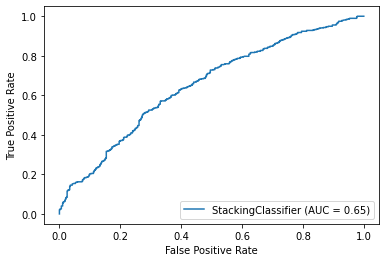

In [82]:
# Explicitly create a figure and axis
roc_disp = plot_roc_curve(model, X_val_resampled, y_val_resampled)
fig = plt.gcf()  # Get the current figure (gcf)


plt.savefig('/kaggle/working/bert_large_roc_curve.png')
plt.show()

In [83]:
from sklearn.metrics import classification_report
print(classification_report(y_val_resampled, y_pred))

              precision    recall  f1-score   support

       False       0.61      0.62      0.61       474
        True       0.61      0.61      0.61       474

    accuracy                           0.61       948
   macro avg       0.61      0.61      0.61       948
weighted avg       0.61      0.61      0.61       948



In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [85]:
cm = confusion_matrix(y_val_resampled, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)

<Figure size 432x288 with 0 Axes>

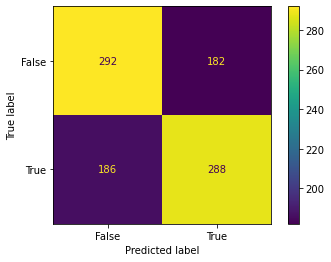

In [86]:
fig = plt.gcf()  # Get the current figure (gcf)
disp.plot()
plt.savefig('/kaggle/working/bert_small_confusion_mat.png')
plt.show()